This notebook contains a step-by-step guide on predicting nba game-winner using player-ratings.

We will be using 'PlayerRatingGenerator' along iwth other tools developed within the spforge package. PlayerRatingGenerator is at it's most simplest core comparable to an Elo-rating-model - but where ratings follow individual players. 
Below are some examples of additional functionality it supports:

* Ratings can change faster when player has played very few recent matches.
* Ratings can change faster when player switches team
* Ratings do not update purely on win/loss. Rather any metric or a combination of metrics with separate weights can be used.
* The initial rating a player receives can be relative to the rating of his team or as a quantile of the distribution of ratings within the league he is participating within (or a combination)
* In sports with multiple leagues, the user can specifify initial priors on how strong the various leagues are relative to each other.
* The strenght of the leagues can also develop dynamically in which case the rating-generator will update these automatically when players from different leagues play against each other.
* Supports partial participation in a match. 



In [1]:
import pandas as pd
df = pd.read_parquet("data/game_player_subsample.parquet")
df.head()

,team_id,start_date,game_id,player_id,player_name,start_position,team_id_opponent,points,game_minutes,minutes,won,plus_minus,location,score,score_opponent
38956,1610612755,2022-10-18,0022200001,202699,Tobias Harris,F,1610612738,18.0,48.0,34.233,0,-1.0,away,117,126
38957,1610612755,2022-10-18,0022200001,200782,P.J. Tucker,F,1610612738,6.0,48.0,33.017,0,-6.0,away,117,126
38958,1610612755,2022-10-18,0022200001,203954,Joel Embiid,C,1610612738,26.0,48.0,37.267,0,-13.0,away,117,126
38959,1610612755,2022-10-18,0022200001,1630178,Tyrese Maxey,G,1610612738,21.0,48.0,38.200,0,-6.0,away,117,126
38960,1610612755,2022-10-18,0022200001,201935,James Harden,G,1610612738,35.0,48.0,37.267,0,1.0,away,117,126


To start by, we implement a simple rating-model which only uses the result of the match to update wins losses

In [2]:
from spforge import ColumnNames
from spforge.ratings import PlayerRatingGenerator
column_names = ColumnNames(
    team_id="team_id",
    match_id="game_id",
    start_date="start_date",
    player_id="player_id"    
)
rating_generator = PlayerRatingGenerator(
    performance_column="won",
    column_names=column_names,
    suffix='_won'
)
df = rating_generator.transform_historical(df)
df[['game_id','team_id', 'team_id_opponent', 'player_name',*rating_generator.features_out]].tail()


,game_id,team_id,team_id_opponent,player_name,rating_difference_projected_won
19867,0022200777,1610612756,1610612737,Deandre Ayton,30.531276
19868,0022200777,1610612756,1610612737,Jock Landale,30.531276
19869,0022200777,1610612756,1610612737,Cameron Johnson,30.531276
19870,0022200777,1610612756,1610612737,Saben Lee,30.531276
19871,0022200777,1610612756,1610612737,Ish Wainright,30.531276


Below we are doing a quick sanity check to ensure that the team with a positive rating_difference wins over 50% of the time.

In [3]:
df[df['rating_difference_projected_won']>0]['won'].mean()

np.float64(0.5637775960752248)

Because the ratings are player-based and updates after each match, we can look up the most up-to-date ratings of selected players.

In [4]:
player_id_stephen_curry = df[df['player_name']=='Stephen Curry']['player_id'].iloc[0]
rating_generator.player_ratings[player_id_stephen_curry]

PlayerRating(id=201939, rating_value=963.0461009203528, name=None, games_played=36.0, last_match_day_number=19389, confidence_sum=29.64, prev_rating_changes=None, most_recent_team_id=1610612744)

In [5]:
player_id_demar_derozan= df[df['player_name']=='DeMar DeRozan']['player_id'].iloc[0]
rating_generator.player_ratings[player_id_demar_derozan]

PlayerRating(id=201942, rating_value=np.float64(930.9363739417606), name=None, games_played=47.0, last_match_day_number=19388, confidence_sum=40.760000000000005, prev_rating_changes=None, most_recent_team_id=1610612741)

To convert the rating-difference to game-winner probability we train and predict with a logistic regression below.

In [6]:
from sklearn.linear_model import LogisticRegression
#Aggregates to game-team level (since ratings were initially on game-player level)
game_team_grouped = df.groupby(['game_id', 'team_id', 'won'])['rating_difference_projected_won'].mean().reset_index()
game_winner_model_logistic = LogisticRegression()
game_winner_model_logistic.fit(game_team_grouped[['rating_difference_projected_won']], game_team_grouped['won'])
game_team_grouped['game_winner_probability'] = game_winner_model_logistic.predict_proba(game_team_grouped[['rating_difference_projected_won']])[:,1]

game_team_grouped.tail()


,game_id,team_id,won,rating_difference_projected_won,game_winner_probability
1547,0022200775,1610612759,0,-245.685180,0.341606
1548,0022200776,1610612761,0,-27.022404,0.481966
1549,0022200776,1610612762,1,27.022404,0.518034
1550,0022200777,1610612737,1,-30.531276,0.479626
1551,0022200777,1610612756,0,30.531276,0.520374


The sharp reader may have noted that we didn't split into train and predict dataset above. While it's always considered a good practice, it's not nearly as essential for simpler models like Linear and Logistic Regression which doesn't overfit. However, regardless we will implement a proper cross-validation approach later in the notebook. For now we skip it to make the code a little simpler.

Below the log-loss is calculated. A log-loss of 0.682 is probably not very good. Simply guessing 0.5 on all matches would yield os 0.693.

In [7]:
from sklearn.metrics import log_loss

log_loss(game_team_grouped['won'], game_team_grouped['game_winner_probability'])

0.6816896975588874

Rather than using the result of the match to update a players rating by. What about using a metric that is a better indication of his performance? The plus_minus value is quite good for that as the value will increase if the team is outscoring the opponent while the player is on the court.

In [8]:
from spforge.ratings import RatingKnownFeatures

column_names = ColumnNames(
    team_id="team_id",
    match_id="game_id",
    start_date="start_date",
    player_id="player_id",
)
rating_generator_plus_minus = PlayerRatingGenerator(
    performance_column="plus_minus",
    non_predictor_known_features_out=[RatingKnownFeatures.PLAYER_RATING, RatingKnownFeatures.TEAM_RATING_PROJECTED,
                  RatingKnownFeatures.OPPONENT_RATING_PROJECTED], # This returns additional information - though we don't have to use it for the final predictio nmodel
    auto_scale_performance=True, # Scales the performance-columns into values between 0 and 1 and ensures a more symmetric distribution
    column_names=column_names,
    suffix='_plus_minus'
)


df = rating_generator_plus_minus.fit_transform(df)
df[['game_id', 'team_id', 'team_id_opponent', 'player_name', *rating_generator_plus_minus.all_rating_features_out]].tail()



,game_id,team_id,team_id_opponent,player_name,rating_difference_projected_plus_minus,player_rating_plus_minus,team_rating_projected_plus_minus,opponent_rating_projected_plus_minus
19867,0022200777,1610612756,1610612737,Deandre Ayton,7.897116,935.505193,987.367968,979.470852
19868,0022200777,1610612756,1610612737,Jock Landale,7.897116,1003.395322,987.367968,979.470852
19869,0022200777,1610612756,1610612737,Cameron Johnson,7.897116,1047.664310,987.367968,979.470852
19870,0022200777,1610612756,1610612737,Saben Lee,7.897116,975.376976,987.367968,979.470852
19871,0022200777,1610612756,1610612737,Ish Wainright,7.897116,997.361881,987.367968,979.470852


In the player_rating_plus_minus column above we can see that each player has quite different player_ratings.
Below we see that Stephen Curry's rating is higher reflecting a shift toward evaluating his individual performance.

In [9]:
rating_generator_plus_minus.player_ratings[player_id_stephen_curry]

PlayerRating(id=201939, rating_value=1039.7642964639754, name=None, games_played=36.0, last_match_day_number=19389, confidence_sum=29.64, prev_rating_changes=None, most_recent_team_id=1610612744)

In [10]:
game_team_grouped_plus_minus = df.groupby(['game_id', 'team_id', 'won'])['rating_difference_projected_plus_minus'].mean().reset_index()

game_winner_model_plus_minus_logistic = LogisticRegression()
game_winner_model_plus_minus_logistic.fit(game_team_grouped_plus_minus[['rating_difference_projected_plus_minus']], game_team_grouped_plus_minus['won'])
game_team_grouped_plus_minus['game_winner_probability'] = game_winner_model_plus_minus_logistic.predict_proba(game_team_grouped_plus_minus[['rating_difference_projected_plus_minus']])[:,1]

log_loss(game_team_grouped_plus_minus['won'], game_team_grouped_plus_minus['game_winner_probability'])

0.6772364249872951

The log-loss improved as a consequence. Although we can probably do better.
One issue with how we are generating predictions is that we are taking the mean of all ratings from each player within a team per game.
However, in reality players play a different amount of minutes.

To address this we can calculate the 'participation_weight' (ratio of minutes played compared to game-length) and update our Column Names with the new column. When we regenrate the ratings, the ream_ratings will automatically weight players with a higher participation_weight.


In [11]:
df['participation_weight'] = df['minutes']/df['game_minutes'].mean()

column_names_participation_weight = ColumnNames(
    team_id="team_id",
    match_id="game_id",
    start_date="start_date",
    player_id="player_id",
    participation_weight='participation_weight'
)

rating_generator_plus_minus_participation_weight = PlayerRatingGenerator(
    performance_column="plus_minus",
    non_predictor_known_features_out=[RatingKnownFeatures.PLAYER_RATING, RatingKnownFeatures.TEAM_RATING_PROJECTED,
                  RatingKnownFeatures.OPPONENT_RATING_PROJECTED],
    auto_scale_performance=True,
    column_names=column_names_participation_weight,
    suffix='_plus_minus_pw'
)

df = rating_generator_plus_minus_participation_weight.fit_transform(df)
df[['game_id', 'team_id', 'team_id_opponent', 'player_name', *rating_generator_plus_minus_participation_weight.all_rating_features_out]].tail()


,game_id,team_id,team_id_opponent,player_name,rating_difference_projected_plus_minus_pw,player_rating_plus_minus_pw,team_rating_projected_plus_minus_pw,opponent_rating_projected_plus_minus_pw
19867,0022200777,1610612756,1610612737,Deandre Ayton,4.770942,954.335626,1004.674826,999.903884
19868,0022200777,1610612756,1610612737,Jock Landale,4.770942,1024.134460,1004.674826,999.903884
19869,0022200777,1610612756,1610612737,Cameron Johnson,4.770942,1050.337149,1004.674826,999.903884
19870,0022200777,1610612756,1610612737,Saben Lee,4.770942,990.649055,1004.674826,999.903884
19871,0022200777,1610612756,1610612737,Ish Wainright,4.770942,1027.842110,1004.674826,999.903884


In [12]:
game_team_grouped_plus_minus_projected = df.groupby(['game_id', 'team_id', 'won'])['rating_difference_projected_plus_minus_pw'].mean().reset_index()

model_plus_minus_projected = LogisticRegression()
model_plus_minus_projected.fit(game_team_grouped_plus_minus_projected[['rating_difference_projected_plus_minus_pw']], game_team_grouped_plus_minus_projected['won'])
game_team_grouped_plus_minus_projected['game_winner_probability'] = model_plus_minus_projected.predict_proba(game_team_grouped_plus_minus_projected[['rating_difference_projected_plus_minus_pw']])[:,1]

log_loss(game_team_grouped_plus_minus_projected['won'], game_team_grouped_plus_minus_projected['game_winner_probability'])

0.6719891316272427

This result in a further improvement. 

We could also add additional features to our prediction-model, the home-away feature 'location' column is an obvious candidate. We would, however, need to one-hot-encode the feature as logistic regression can't work with categorical features directly. 

To implement this feature we utilise GameTeamPredictor and SklearnPredictor
GameTeamPredictor aggregates to to game-team level before calling another predictor.
The predictor we use in this example is SklearnPredictor which is simply a wrapper around any Sklearn-type-estimator.
The sklearn-estimator used is a Logistic Regression. Thus, the functionality implemented below should be the same as we what did before - except that we added location and one-hot-encoded it.




In [13]:
from spforge.predictor import GroupByPredictor, SklearnPredictor
game_winner_predictor = GroupByPredictor(
    granularity=[column_names.match_id, column_names.team_id],
    predictor=SklearnPredictor(
        features=["location", 'rating_difference_projected_plus_minus_pw'],
        target="won", 
        estimator=LogisticRegression(),
        pred_column = 'game_winner_probability_location'
    ),
    one_hot_encode_cat_features=True, #one-hot-encodes any categorical features
)

game_winner_predictor.train(df)
df = game_winner_predictor.predict(df)
log_loss(df['won'], df[game_winner_predictor.pred_column])


0.6529876686916027

Adding location led to a quite significant improvement in the log-loss. Could we further improve it? 
Let's try and add various lagged-features to our model.

In [14]:
from spforge.transformers import LagTransformer
lag_player_transformer = LagTransformer(
    features=['plus_minus'],
    granularity=['player_id'],
    lag_length=4 
)

df['score_difference'] = df['score'] - df['score_opponent']

lag_team_transformer = LagTransformer(
    features=['score_difference'],
    granularity=['team_id'],
    lag_length=4 
)


df = lag_player_transformer.transform_historical(df, column_names=column_names_participation_weight)
df = lag_team_transformer.transform_historical(df, column_names=column_names_participation_weight)

game_winner_predictor_lags = GroupByPredictor(
    granularity=[column_names.match_id, column_names.team_id],
    predictor=SklearnPredictor(
        features=["location", 'rating_difference_projected_plus_minus_pw', *lag_player_transformer.features_out, *lag_team_transformer.features_out],
        target="won", 
            impute_missing_values=True,
        estimator=LogisticRegression(),
        pred_column = 'game_winner_probability_location_lags'
    ),
    scale_features=True,
    one_hot_encode_cat_features=True, #one-hot-encodes any categorical features
)

game_winner_predictor_lags.train(df)
df = game_winner_predictor_lags.predict(df)
log_loss(df['won'], df[game_winner_predictor_lags.pred_column])


0.6517328998271625

Logloss improved! Can we then conclude the new lagged features make the model better???

No. While we initially began with a very simple model with only rating-difference as the sole feature. When we add more features and evaluate on the same data we train with, log-loss is only gonna improve. Below the coefficients for each feature is displayed. And we see some unintuitive results: The 4th most important feature is lag 4 plus minus and the cofficient is negative. That doesn't make sense

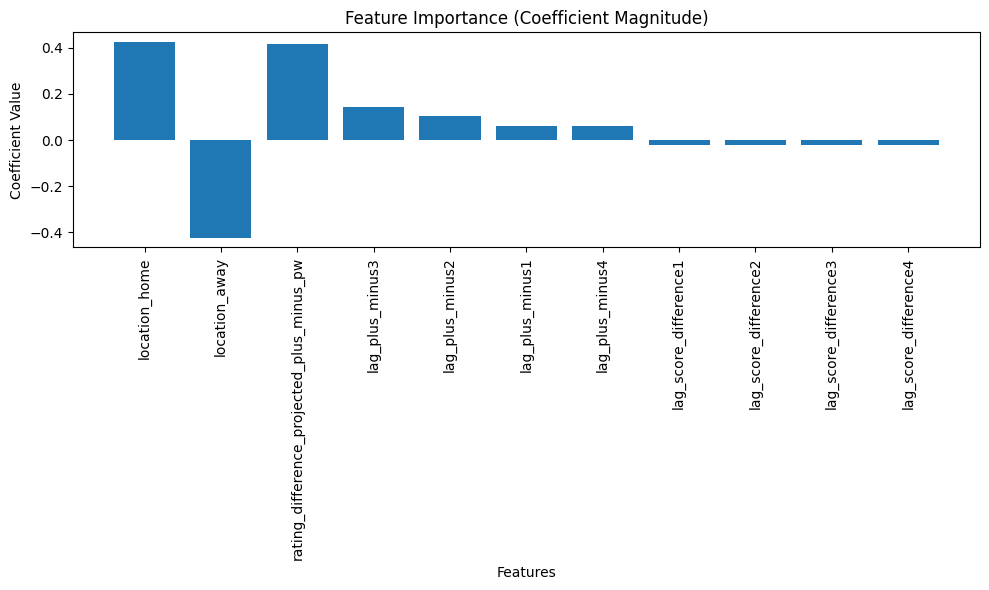

In [15]:
import matplotlib.pyplot as plt

coef_ = game_winner_predictor_lags.predictor.estimator.coef_.tolist()[0]
features = game_winner_predictor_lags.predictor.features
sorted_pairs = sorted(zip(features, coef_), key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_coef = zip(*sorted_pairs)

plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_coef)
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Feature Importance (Coefficient Magnitude)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


To properly evaluate a more complex model that may overfit we need to use cross-validation. 

In [16]:
from spforge import Pipeline

from spforge.cross_validator import MatchKFoldCrossValidator
from spforge.scorer import SklearnScorer


cross_validator_with_lags = MatchKFoldCrossValidator(
    match_id_column_name='game_id',
    date_column_name='start_date',
    predictor = game_winner_predictor_lags,
)
log_loss_scorer_with_lags = SklearnScorer(pred_column=game_winner_predictor_lags.pred_column, scorer_function=log_loss, target='won')
df = cross_validator_with_lags.generate_validation_df(df, add_train_prediction=True)
print(f"logloss score with lags {cross_validator_with_lags.cross_validation_score(df, scorer=log_loss_scorer_with_lags)}")

cross_validator_without_lags = MatchKFoldCrossValidator(
    match_id_column_name='game_id',
    date_column_name='start_date',
    predictor = game_winner_predictor,
)
log_loss_scorer = SklearnScorer(pred_column=game_winner_predictor.pred_column, scorer_function=log_loss, target='won')
df = cross_validator_without_lags.generate_validation_df(df, add_train_prediction=True)
print(f"logloss score without lags {cross_validator_without_lags.cross_validation_score(df, scorer=log_loss_scorer )}")



logloss score with lags 0.6548684726654973
logloss score without lags 0.6548575211108845


The log-loss still shows a small improvement with the lags. Next step could be to calculate whether the difference is statistically significant - but that's beyond the scope of this notebook guide. 

But let's assume that we decide to keep the new lagged features as part of our "final model". Going through all of the steps above may be a little tedious. And thus it is recommended to utilise a Pipeline to handle all of the steps. A benefit of using a pipeline is that it will also ensure that if you use it on future matches the calculations will be performed correctly. 

In [17]:
#Reloads everything from scratch to ensure we are not using previously added columns
df = pd.read_parquet("data/game_player_subsample.parquet")
df['participation_weight'] = df['minutes'] / df['game_minutes'].mean()
df['score_difference'] = df['score'] - df['score_opponent']

game_winner_pipeline = Pipeline(
    lag_transformers=[lag_player_transformer, lag_team_transformer],
    rating_generators=rating_generator_plus_minus_participation_weight,
    predictor=GroupByPredictor(
        granularity=[column_names_participation_weight.match_id, column_names_participation_weight.team_id],
        predictor=SklearnPredictor(
            features=['location'], #only feaure we manually specify. Other lag and rating generator features added automatically
            target="won",
            estimator=LogisticRegression(),
        ),
        impute_missing_values=True,
        one_hot_encode_cat_features=True,  # one-hot-encodes any categorical features
    ),
    column_names=column_names_participation_weight,
)

cross_validator = MatchKFoldCrossValidator(
    match_id_column_name='game_id',
    date_column_name='start_date',
    predictor = game_winner_pipeline,
)

log_loss_scorer = SklearnScorer(pred_column=game_winner_pipeline.pred_column, scorer_function=log_loss, target='won')
df = cross_validator.generate_validation_df(df, add_train_prediction=True)
print(f"logloss score Pipeline {cross_validator.cross_validation_score(df, scorer=log_loss_scorer )}")



logloss score Pipeline 0.6551052070147183


There is one big problem left with our approach - and it's actually a big one.
We have leakage - meaning our prediction model is using information that is first available in the future. 
When we added participation_weight to our model, it calculated the team-ratings based on the minutes played during the game. But we don't know the amount of minutes a player plays before the match starts. 

Thus, what actually should be used is "predicted minutes" instead of "actual minutes" in determining a team's projected rating. 

To determine 'predicted minutes' we will utilise a simple RollingMean.


In [18]:
from spforge.transformers import   RollingWindowTransformer

rolling_mean_transformer = RollingWindowTransformer(
    window=15,
    features=['minutes'],
    granularity=['player_id'], 
    update_column='game_id'
)
df = rolling_mean_transformer.transform_historical(df, column_names=column_names)
df['projected_participation_weight'] = df[rolling_mean_transformer.features_out[0]] / 48
df['projected_participation_weight'] = df['projected_participation_weight'].fillna(df['projected_participation_weight'].mean())
df.tail()

,won_prediction,game_id,player_name,minutes,start_position,won,points,team_id,start_date,score_opponent,team_id_opponent,score_difference,plus_minus,game_minutes,participation_weight,player_id,score,location,rolling_mean_minutes15,projected_participation_weight
19867,0.630617,0022200777,Saben Lee,21.483,,0,6.0,1610612756,2023-02-01,132,1610612737,-32,-6.0,48.0,0.444028,1630240,100,home,7.009681,0.146035
19868,0.630617,0022200777,Bismack Biyombo,10.000,,0,2.0,1610612756,2023-02-01,132,1610612737,-32,-9.0,48.0,0.206688,202687,100,home,11.590484,0.241468
19869,0.630617,0022200777,Josh Okogie,15.367,,0,2.0,1610612756,2023-02-01,132,1610612737,-32,-10.0,48.0,0.317618,1629006,100,home,16.012236,0.333588
19870,0.630617,0022200777,Ish Wainright,18.950,,0,4.0,1610612756,2023-02-01,132,1610612737,-32,-6.0,48.0,0.391674,1630688,100,home,14.962360,0.311716
19871,0.630617,0022200777,Jock Landale,10.517,,0,6.0,1610612756,2023-02-01,132,1610612737,-32,6.0,48.0,0.217374,1629111,100,home,14.275182,0.297400


The actual minutes played them selves still contain value as a players rating should update faster the more he plays during a match. Whereas if he only played 10 seconds, his rating should barely change.

We don't need to worry about managing this logic ourself. It's all taken care of by simply adding  'projected_participation_weight' to ColumnNames



In [19]:
column_names_projected_participation_weight = ColumnNames(
    team_id="team_id",
    match_id="game_id",
    start_date="start_date",
    player_id="player_id",
    participation_weight='participation_weight',
    projected_participation_weight='projected_participation_weight'
)


rating_generator_plus_minus_projected_participation_weight = PlayerRatingGenerator(
    performance_column="plus_minus",
    non_predictor_known_features_out=[RatingKnownFeatures.PLAYER_RATING, RatingKnownFeatures.TEAM_RATING_PROJECTED,
                  RatingKnownFeatures.OPPONENT_RATING_PROJECTED],
    auto_scale_performance=True,
    column_names=column_names_participation_weight,
    suffix='_plus_minus_pw'
)

game_winner_pipeline = Pipeline(
    lag_transformers=[lag_player_transformer, lag_team_transformer],
    rating_generators=rating_generator_plus_minus_projected_participation_weight,
    predictor=GroupByPredictor(
        granularity=[column_names_participation_weight.match_id, column_names_participation_weight.team_id],
        predictor=SklearnPredictor(
            features=['location'],
            pred_column='game_winner_probability_projected_',
            target="won",
            estimator=LogisticRegression(),
        ),
        impute_missing_values=True,
        one_hot_encode_cat_features=True,  # one-hot-encodes any categorical features
    ),
    column_names=column_names_projected_participation_weight,
)


cross_validator = MatchKFoldCrossValidator(
    match_id_column_name='game_id',
    date_column_name='start_date',
    predictor = game_winner_pipeline,
)
log_loss_scorer = SklearnScorer(pred_column=game_winner_pipeline.pred_column, scorer_function=log_loss, target='won')
df = cross_validator.generate_validation_df(df, add_train_prediction=True)
cross_validator.cross_validation_score(df, scorer=log_loss_scorer )

0.6559908453237284

Okay, log-loss fell a bit - that was expected since we removed leakage.

Now to the final part of this guide. Until now we only used a single column for the performance-value. We started by using the binary win/loss and then quickly identified that plus-minus on a player-level is much better. But it is actually possible to combine multiple columns together as demonstrated below.

In [ ]:
df['points_per_minute'] = df['points'] / df['minutes']

rating_generator_weights = PlayerRatingGenerator(
    performance_column="plus_minus",
    non_predictor_known_features_out=[RatingKnownFeatures.PLAYER_RATING, RatingKnownFeatures.TEAM_RATING_PROJECTED,
                  RatingKnownFeatures.OPPONENT_RATING_PROJECTED],
    auto_scale_performance=True,
    column_names=column_names_projected_participation_weight,
    suffix='_plus_minus_pw',
    performance_weights = [
        {
            "name": 'points_per_minute',
            'weight':0.15
        },
         {
            "name": 'plus_minus',
            'weight':0.75
        },
             {
            "name": 'won',
            'weight':0.1
        }
    ]
)

game_winner_pipeline = Pipeline(
    lag_transformers=[lag_player_transformer, lag_team_transformer],
    rating_generators=rating_generator_weights,
    predictor=GroupByPredictor(
        granularity=[column_names_participation_weight.match_id, column_names_participation_weight.team_id],
        predictor=SklearnPredictor(
            features=['location'],
            pred_column='game_winner_probability_projected_',
            target="won",
            estimator=LogisticRegression(),
        ),
        impute_missing_values=True,
        one_hot_encode_cat_features=True,  # one-hot-encodes any categorical features
    ),
    column_names=column_names_projected_participation_weight,
)

cross_validator = MatchKFoldCrossValidator(
    match_id_column_name='game_id',
    date_column_name='start_date',
    predictor = game_winner_pipeline,
)
log_loss_scorer = SklearnScorer(pred_column=game_winner_pipeline.pred_column, scorer_function=log_loss, target='won')
df = cross_validator.generate_validation_df(df, add_train_prediction=True)
cross_validator.cross_validation_score(df, scorer=log_loss_scorer )

This change reduced logloss. But if we were using a real-dataset (and not this simplified subsampled data), we would have access to many more data-points that would be worth exploring.